In [ ]:
!pip install transformers seqeval[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.7 MB/s 
     |████████████████████████████████| 120 kB 73.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=208532705d9ef3ebbbc61b331878086d2c5c579edd8f02e7175fa96667b9c551
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def data_loading(path):
  sentence_no = 1
  datas = []
  wr = False
  with open(path) as f:
    for line in f:
      if line == '\n':
        sentence_no += 1
        wr = False
      else:
        line = line.replace('\n', '')
        splits = line.split('\t')
        word = splits[0]
        tag = splits[1]
        if not wr:
          wr = True
          sn = sentence_no
        else:
          sn = None
        datas.append({"Sentence #": sn, 
                      "Word": word,
                      "Tag": tag})
  df = pd.DataFrame(datas)
  print(df)
  return df


In [ ]:
test_path = "pl/wdc_exact/test.txt"
train_path = "pl/wdc_exact/train.txt"
val_path = "pl/wdc_exact/valid.txt"

In [ ]:
data_train = data_loading(train_path)
data_test = data_loading(test_path)
data_valid = data_loading(val_path)


       Sentence #       Word    Tag
0             1.0       Mola  B-PER
1             NaN      Ultra      O
2             NaN    Chłonne      O
3             NaN   Ręczniki      O
4             NaN  papierowe      O
...           ...        ...    ...
16393         NaN   gazowany      O
16394         NaN          2      O
16395         NaN          x      O
16396         NaN        1,5      O
16397         NaN          l      O

[16398 rows x 3 columns]
      Sentence #         Word    Tag
0            1.0     MOUNTAIN  B-PER
1            NaN          DEW  I-PER
2            NaN        Napój      O
3            NaN     gazowany      O
4            2.0          Air  B-PER
...          ...          ...    ...
3663         NaN        Sport      O
3664         NaN    Naturalna      O
3665         NaN         woda      O
3666         NaN    mineralna      O
3667         NaN  niegazowana      O

[3668 rows x 3 columns]
      Sentence #      Word    Tag
0            1.0     Ariel  B-PER
1    

In [ ]:
data_train.count()

Sentence #     1989
Word          16398
Tag           16398
dtype: int64

In [ ]:
print("Number of tags: {}".format(len(data_train.Tag.unique())))
frequencies = data_train.Tag.value_counts()
frequencies

Number of tags: 5


O        11845
B-PER     1841
I-ORG     1251
B-ORG     1221
I-PER      240
Name: Tag, dtype: int64

In [ ]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('ORG', 2472), ('PER', 2081)]


In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data_valid = data_valid.fillna(method='ffill')

In [ ]:
def data_con(data):
  data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
  data['word_labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))

for d in [data_train, data_test, data_valid]:
  data_con(d)

In [ ]:
label2id = {k: v for v, k in enumerate(data_train.Tag.unique())}
id2label = {v: k for v, k in enumerate(data_train.Tag.unique())}
label2id

{'B-PER': 0, 'O': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4}

In [ ]:
data_train = data_train[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data_test = data_test[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data_valid = data_valid[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)

In [ ]:
len(data_train)

1664

In [ ]:
data_train.iloc[41].sentence

'ACE ULTRA Silny żel Flowers'

In [ ]:
data_train.iloc[41].word_labels

'B-PER,O,O,O,O'

In [ ]:
MAX_LEN = 32
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
EPOCHS = 5
LEARNING_RATE = 1e-04
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained("dkleczek/bert-base-polish-cased-v1")

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]  
        word_labels = self.data.word_labels[index]  
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)
        
        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]
        
        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]
        
        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
training_set = dataset(data_train, tokenizer, MAX_LEN)
testing_set = dataset(data_test, tokenizer, MAX_LEN)
validation_set = dataset(data_valid, tokenizer, MAX_LEN)

In [ ]:
training_set[0]

{'ids': tensor([    2, 14489,   416, 31789, 23608,  8404, 10054,  6375, 17882,  1097,
            24, 40079,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'targets': tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1])}

In [ ]:
training_set[0]["ids"]

tensor([    2, 14489,   416, 31789, 23608,  8404, 10054,  6375, 17882,  1097,
           24, 40079,     4,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
validation_loader = DataLoader(validation_set, **valid_params)

In [ ]:
model = BertForTokenClassification.from_pretrained("dkleczek/bert-base-polish-cased-v1", 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of the model checkpoint at dkleczek/bert-base-polish-cased-v1 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not ini

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(60000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.0871, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 32, 5])

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the bert model
from seqeval.metrics import classification_report


def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    val_loss, val_accuracy = 0, 0
    nb_val_examples, nb_val_steps = 0, 0
    
    tr_preds, tr_labels = [], []

    val_preds, val_labels = [], []

    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
          
           
        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_preds.extend(predictions)
        tr_labels.extend(targets)
        
        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    for idx, batch in enumerate(validation_loader):
        if idx % 100 == 0:
          print(f"Running validation: {idx}")
        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, val_logits = outputs.loss, outputs.logits
        val_loss += loss.item()

        nb_val_steps += 1
        nb_val_examples += targets.size(0)

        flattened_targets = targets.view(-1)
        active_logits = val_logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)

        active_accuracy = mask.view(-1) == 1
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        val_preds.extend(predictions)
        val_labels.extend(targets)
        
        tmp_val_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        val_accuracy += tmp_val_accuracy

    val_epoch_loss = val_loss / nb_val_steps
    val_accuracy_loss = val_accuracy / nb_val_steps

    print(f"Validaton loss epoch: {val_epoch_loss}")
    print(f"Validaton accuracy epoch: {val_accuracy_loss}")

    tr_epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps

    print(f"Training loss epoch: {tr_epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

    labels = [id2label[id.item()] for id in val_labels]
    predictions = [id2label[id.item()] for id in val_preds]

    return {
        "epoch": epoch,
        "val_epoch_loss": val_epoch_loss, 
        "val_accuracy_loss": val_accuracy_loss,
        "tr_epoch_loss": tr_epoch_loss,
        "tr_accuracy": tr_accuracy,
        "report": classification_report([labels], [predictions], output_dict=True)
        }

In [ ]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(targets)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy
    
    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [ ]:
torch.manual_seed(0)
import random
random.seed(0)

training_results = []
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    result = train(epoch)
    print(result)
    training_results.append(result)

print(training_results)

Training epoch: 1
Training loss per 100 training steps: 1.5848395824432373
Training loss per 100 training steps: 0.1411457418344251
Training loss per 100 training steps: 0.1241260519881376
Training loss per 100 training steps: 0.11003122272502099
Training loss per 100 training steps: 0.10026144780720261
Running validation: 0
Running validation: 100
Running validation: 200
Validaton loss epoch: 0.08559315268397696
Validaton accuracy epoch: 0.9295518359718378
Training loss epoch: 0.09707054528205292
Training accuracy epoch: 0.9368323350847207
{'epoch': 0, 'val_epoch_loss': 0.08559315268397696, 'val_accuracy_loss': 0.9295518359718378, 'tr_epoch_loss': 0.09707054528205292, 'tr_accuracy': 0.9368323350847207, 'report': {'ORG': {'precision': 0.6395864106351551, 'recall': 0.800369685767098, 'f1-score': 0.7110016420361248, 'support': 541}, 'PER': {'precision': 0.9014778325123153, 'recall': 0.9265822784810127, 'f1-score': 0.9138576779026216, 'support': 790}, 'micro avg': {'precision': 0.78240429

In [ ]:
print(training_results[0]['report']['macro avg']['f1-score'])

0.9300956009934338


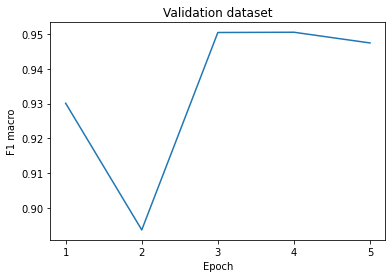

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot([x+1 for x in range(len(training_results))], [it['report']['macro avg']['f1-score'] for it in training_results])
plt.ylabel('F1 macro')
plt.xlabel('Epoch')
plt.title("Validation dataset")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.show()

In [ ]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.10236530750989914
Validation loss per 100 evaluation steps: 0.07015922862968965
Validation loss per 100 evaluation steps: 0.07244938624306323
Validation Loss: 0.07336252193518226
Validation Accuracy: 0.948983463525225


In [ ]:
from seqeval.metrics import classification_report

cr = str(classification_report([labels], [predictions]))
d = parse_classification_report(cr)
print(report_to_latex_table(d))

print('\n\n\n\n\n')

cr = str(classification_report([predictions], [labels]))
d = parse_classification_report(cr)
print(report_to_latex_table(d))

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
ORG & 0.64 & 0.75 & 0.69 & 424\\
PER & 0.91 & 0.97 & 0.94 & 924\\
\midrule
micro avg & 0.82 & 0.9 & 0.86 & 1348\\
macro avg & 0.77 & 0.86 & 0.81 & 1348\\
avg & 0.82 & 0.9 & 0.86 & 1348\\
\end{tabular}
\end{table}






\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
ORG & 0.75 & 0.64 & 0.69 & 496\\
PER & 0.97 & 0.91 & 0.94 & 982\\
\midrule
micro avg & 0.9 & 0.82 & 0.86 & 1478\\
macro avg & 0.86 & 0.77 & 0.81 & 1478\\
avg & 0.89 & 0.82 & 0.85 & 1478\\
\end{tabular}
\end{table}


In [ ]:
predictions

['O',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'I-ORG',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'O',
 'I-ORG',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'B-ORG',
 'B-ORG',
 'O',
 'I-ORG',
 'O',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'I-ORG',
 'O',
 'B-PER',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-ORG',
 'O',
 'I-ORG',
 'O',
 'B-PER',
 'B-PER',
 'B-PER',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'B-PER',
 'B-